In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from scipy import stats
from sklearn.metrics import cohen_kappa_score
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# Set publication-quality plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.dpi'] = 100


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✗ Not found: curated_extractive_results.csv
✗ Not found: pilot_extractive_results.csv

Current directory: /content
Files here: ['.config', 'drive', 'sample_data']


### Load Data

In [5]:
curated_results = pd.read_csv('/content/drive/MyDrive/Dissertation/curated_extractive_results.csv')
pilot_results = pd.read_csv('/content/drive/MyDrive/Dissertation/pilot_extractive_results.csv')

print("✓ Files loaded successfully!")

# ==========================================
# VERIFY DATA STRUCTURE
# ==========================================

print("\n📊 CURATED DATASET:")
print("-"*40)
print(f"Shape: {curated_results.shape}")
print(f"Columns: {curated_results.columns.tolist()}")

print("\n📊 PILOT DATASET:")
print("-"*40)
print(f"Shape: {pilot_results.shape}")
print(f"Columns: {pilot_results.columns.tolist()}")

# ==========================================
# CHECK A SAMPLE
# ==========================================

print("\n📝 SAMPLE FROM CURATED (first row):")
print("-"*40)
print("Original Excerpt (first 200 chars):")
print(str(curated_results.iloc[0]['Excerpt'])[:200])
print("\nLead-2 Summary (first 200 chars):")
print(str(curated_results.iloc[0]['lead2_summary'])[:200])
print("\nTextRank Summary (first 200 chars):")
print(str(curated_results.iloc[0]['textrank_summary'])[:200])

print("\n" + "="*60)
print("✅ Data loaded successfully! Ready for analysis.")
print("="*60)

✓ Files loaded successfully!

📊 CURATED DATASET:
----------------------------------------
Shape: (132, 7)
Columns: ['ID', 'Excerpt', 'Feature', 'SubFeature', 'GoldSummary', 'lead2_summary', 'textrank_summary']

📊 PILOT DATASET:
----------------------------------------
Shape: (351, 7)
Columns: ['ID', 'SPEAKER', 'TEXT', 'LING_FEATURES', 'NOTES', 'lead2_summary', 'textrank_summary']

📝 SAMPLE FROM CURATED (first row):
----------------------------------------
Original Excerpt (first 200 chars):
I might have seen him in the lobby

Lead-2 Summary (first 200 chars):
I might have seen him in the lobby

TextRank Summary (first 200 chars):
I might have seen him in the lobby

✅ Data loaded successfully! Ready for analysis.


### Feature Detection Functions

In [7]:
def define_linguistic_patterns():
    """Define regex patterns for linguistic feature detection"""

    patterns = {
        'hedges': {
            'pattern': r'\b(I think|I believe|maybe|perhaps|possibly|probably|seems?|appear(?:s|ed)?|'
                      r'kind of|sort of|somewhat|quite|rather|fairly|pretty much|basically|actually|'
                      r'in my opinion|if I recall|as far as I know)\b',
            'weight': 1.0
        },
        'modals': {
            'pattern': r'\b(might|may|could|would|should|must|ought to|'
                      r'can|cannot|can\'t|couldn\'t|wouldn\'t|shouldn\'t)\b',
            'weight': 0.8
        },
        'conditionals': {
            'pattern': r'\b(if|unless|provided that|assuming|supposing|whether|'
                      r'in case|as long as|even if|only if)\b.*\b(then|would|could|might)\b',
            'weight': 0.9
        },
        'temporals': {
            'pattern': r'\b(before|after|during|while|when|then|at that time|at the time|'
                      r'previously|subsequently|meanwhile|simultaneously|eventually|'
                      r'back then|later on|earlier)\b',
            'weight': 0.7
        },
        'disfluencies': {
            'pattern': r'\b(um+|uh+|er+|ah+|mm+|hm+)\b|'
                      r'\b(\w+)-\1\b|'  # Repetitions like "I-I"
                      r'\b(\w+)\s+\1\b|'  # Word repetitions
                      r'\.\.\.|—|--',  # Pauses
            'weight': 1.0
        }
    }

    return patterns

def extract_features(text, patterns):
    """Extract linguistic features from text"""

    if pd.isna(text) or not text:
        return {cat: [] for cat in patterns.keys()}

    text = str(text).lower()
    features = {}

    for category, config in patterns.items():
        matches = re.findall(config['pattern'], text, re.IGNORECASE)
        features[category] = matches

    return features

def count_features(text, patterns):
    """Count linguistic features in text"""

    features = extract_features(text, patterns)
    counts = {cat: len(matches) for cat, matches in features.items()}
    counts['total'] = sum(counts.values())

    return counts

In [8]:
# ==========================================
# TEST ON SAMPLE TEXT
# ==========================================

print("\n🔍 Testing feature detection on sample texts...")
print("-"*40)

# Get the patterns
patterns = define_linguistic_patterns()

# Test on a sample with known features
test_text = "Um, I think he might have been there at that time, but I'm not sure. If I recall correctly, uh, maybe it was earlier."

print(f"\nTest text: '{test_text}'")
print("\nFeatures detected:")
test_counts = count_features(test_text, patterns)
for feature, count in test_counts.items():
    if count > 0:
        print(f"  {feature}: {count}")

# ==========================================
# TEST ON ACTUAL DATA
# ==========================================

print("\n📊 Testing on actual data from your CSV...")
print("-"*40)

# Test on first row of curated data
sample_original = curated_results.iloc[0]['Excerpt']
sample_lead2 = curated_results.iloc[0]['lead2_summary']
sample_textrank = curated_results.iloc[0]['textrank_summary']

print("\n1. ORIGINAL TEXT:")
print(f"   Text (first 150 chars): {str(sample_original)[:150]}...")
orig_counts = count_features(sample_original, patterns)
print("   Features found:")
for feature, count in orig_counts.items():
    if count > 0:
        print(f"     {feature}: {count}")

print("\n2. LEAD-2 SUMMARY:")
print(f"   Text (first 150 chars): {str(sample_lead2)[:150]}...")
lead2_counts = count_features(sample_lead2, patterns)
print("   Features found:")
for feature, count in lead2_counts.items():
    if count > 0:
        print(f"     {feature}: {count}")

print("\n3. TEXTRANK SUMMARY:")
print(f"   Text (first 150 chars): {str(sample_textrank)[:150]}...")
textrank_counts = count_features(sample_textrank, patterns)
print("   Features found:")
for feature, count in textrank_counts.items():
    if count > 0:
        print(f"     {feature}: {count}")

# ==========================================
# QUICK PRESERVATION CHECK
# ==========================================

print("\n📈 Quick preservation check for this example:")
print("-"*40)
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    if orig_counts[feature] > 0:
        lead2_preserved = (lead2_counts[feature] / orig_counts[feature]) * 100
        textrank_preserved = (textrank_counts[feature] / orig_counts[feature]) * 100
        print(f"{feature}:")
        print(f"  Original: {orig_counts[feature]} → Lead-2: {lead2_counts[feature]} ({lead2_preserved:.0f}% preserved)")
        print(f"  Original: {orig_counts[feature]} → TextRank: {textrank_counts[feature]} ({textrank_preserved:.0f}% preserved)")

print("\n" + "="*60)
print("✅ Feature detection ready! Next: Calculate metrics for all rows.")
print("="*60)


🔍 Testing feature detection on sample texts...
----------------------------------------

Test text: 'Um, I think he might have been there at that time, but I'm not sure. If I recall correctly, uh, maybe it was earlier.'

Features detected:
  hedges: 3
  modals: 1
  temporals: 2
  disfluencies: 2
  total: 8

📊 Testing on actual data from your CSV...
----------------------------------------

1. ORIGINAL TEXT:
   Text (first 150 chars): I might have seen him in the lobby...
   Features found:
     modals: 1
     total: 1

2. LEAD-2 SUMMARY:
   Text (first 150 chars): I might have seen him in the lobby...
   Features found:
     modals: 1
     total: 1

3. TEXTRANK SUMMARY:
   Text (first 150 chars): I might have seen him in the lobby...
   Features found:
     modals: 1
     total: 1

📈 Quick preservation check for this example:
----------------------------------------
modals:
  Original: 1 → Lead-2: 1 (100% preserved)
  Original: 1 → TextRank: 1 (100% preserved)

✅ Feature detection rea

### Preservation Metrics

In [9]:
#!/usr/bin/env python3
"""
Step 3: Calculate all Section 3.4.1 Metrics
- Feature Retention Rate
- Certainty Inflation
- Disfluency Sanitization Rate
- Complete Feature Loss Rate
"""

import pandas as pd
import numpy as np
import re

print("="*60)
print("STEP 3: CALCULATING SECTION 3.4.1 METRICS")
print("="*60)

# ==========================================
# METRIC 1: FEATURE RETENTION RATE
# ==========================================

def calculate_retention_rates(df, patterns, text_col, summary_col):
    """Calculate feature retention rate for each feature category"""

    retention_results = {
        'hedges': [],
        'modals': [],
        'conditionals': [],
        'temporals': [],
        'disfluencies': [],
        'overall': []
    }

    for idx, row in df.iterrows():
        original = str(row[text_col])
        summary = str(row[summary_col])

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Calculate retention for each feature
        for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
            if orig_counts[feature] > 0:
                retention = min(summ_counts[feature] / orig_counts[feature], 1.0)
            else:
                retention = 1.0  # No features to lose
            retention_results[feature].append(retention)

        # Overall retention
        if orig_counts['total'] > 0:
            overall = min(summ_counts['total'] / orig_counts['total'], 1.0)
        else:
            overall = 1.0
        retention_results['overall'].append(overall)

    # Calculate mean retention rates
    mean_rates = {}
    for feature, rates in retention_results.items():
        mean_rates[feature] = np.mean(rates) * 100

    return retention_results, mean_rates

# ==========================================
# METRIC 2: CERTAINTY INFLATION
# ==========================================

def detect_certainty_inflation(df, text_col, summary_col):
    """Count instances where hedged statements become categorical"""

    inflation_patterns = [
        (r'I think (.*?)(?:\.|,|;|$)', r'\1'),
        (r'I believe (.*?)(?:\.|,|;|$)', r'\1'),
        (r'maybe (.*?)(?:\.|,|;|$)', r'\1'),
        (r'possibly (.*?)(?:\.|,|;|$)', r'\1'),
        (r'probably (.*?)(?:\.|,|;|$)', r'\1'),
        (r'it seems (.*?)(?:\.|,|;|$)', r'\1'),
        (r'perhaps (.*?)(?:\.|,|;|$)', r'\1'),
    ]

    total_inflations = 0
    inflation_examples = []

    for idx, row in df.iterrows():
        original = str(row[text_col]).lower()
        summary = str(row[summary_col]).lower()

        for hedged_pattern, _ in inflation_patterns:
            # Find hedged statements in original
            hedged_matches = re.findall(hedged_pattern, original)

            for match in hedged_matches:
                # Check if hedge is removed in summary
                hedge_phrase = hedged_pattern.split()[0]  # Get "I think", "maybe", etc.
                if hedge_phrase not in summary and match.strip() in summary:
                    total_inflations += 1
                    if len(inflation_examples) < 5:  # Keep first 5 examples
                        inflation_examples.append({
                            'row': idx,
                            'original': f"{hedge_phrase} {match}",
                            'summary': match.strip()
                        })

    return total_inflations, inflation_examples

# ==========================================
# METRIC 3: DISFLUENCY SANITIZATION RATE
# ==========================================

def calculate_disfluency_sanitization(df, patterns, text_col, summary_col):
    """Calculate the rate at which disfluencies are removed"""

    sanitization_rates = []

    for idx, row in df.iterrows():
        original = str(row[text_col])
        summary = str(row[summary_col])

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        if orig_counts['disfluencies'] > 0:
            # Sanitization = what percentage was removed
            retained = min(summ_counts['disfluencies'] / orig_counts['disfluencies'], 1.0)
            sanitization = (1 - retained) * 100
        else:
            sanitization = 0  # No disfluencies to sanitize

        sanitization_rates.append(sanitization)

    mean_sanitization = np.mean(sanitization_rates)

    return sanitization_rates, mean_sanitization

# ==========================================
# METRIC 4: COMPLETE FEATURE LOSS RATE
# ==========================================

def calculate_complete_loss(df, patterns, text_col, summary_col):
    """Calculate percentage of excerpts where ALL features are removed"""

    complete_loss_count = 0
    total_with_features = 0

    for idx, row in df.iterrows():
        original = str(row[text_col])
        summary = str(row[summary_col])

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Only count texts that had features to begin with
        if orig_counts['total'] > 0:
            total_with_features += 1
            if summ_counts['total'] == 0:
                complete_loss_count += 1

    if total_with_features > 0:
        complete_loss_rate = (complete_loss_count / total_with_features) * 100
    else:
        complete_loss_rate = 0

    return complete_loss_rate, complete_loss_count, total_with_features

# ==========================================
# CALCULATE ALL METRICS
# ==========================================

print("\n📊 CALCULATING METRICS FOR CURATED DATASET...")
print("-"*40)

# Get patterns (assuming you've already defined them from Step 2)
patterns = define_linguistic_patterns()

# CURATED - Lead-2
print("\nCurated Lead-2:")
cur_lead2_retention, cur_lead2_means = calculate_retention_rates(
    curated_results, patterns, 'Excerpt', 'lead2_summary'
)
print(f"  Feature Retention Rates:")
for feature, rate in cur_lead2_means.items():
    print(f"    {feature}: {rate:.1f}%")

cur_lead2_inflation, cur_lead2_examples = detect_certainty_inflation(
    curated_results, 'Excerpt', 'lead2_summary'
)
print(f"  Certainty Inflation: {cur_lead2_inflation} instances")

cur_lead2_disf_rates, cur_lead2_disf_mean = calculate_disfluency_sanitization(
    curated_results, patterns, 'Excerpt', 'lead2_summary'
)
print(f"  Disfluency Sanitization Rate: {cur_lead2_disf_mean:.1f}%")

cur_lead2_complete, cur_lead2_complete_count, cur_lead2_total = calculate_complete_loss(
    curated_results, patterns, 'Excerpt', 'lead2_summary'
)
print(f"  Complete Feature Loss: {cur_lead2_complete:.1f}% ({cur_lead2_complete_count}/{cur_lead2_total})")

# CURATED - TextRank
print("\nCurated TextRank:")
cur_textrank_retention, cur_textrank_means = calculate_retention_rates(
    curated_results, patterns, 'Excerpt', 'textrank_summary'
)
print(f"  Feature Retention Rates:")
for feature, rate in cur_textrank_means.items():
    print(f"    {feature}: {rate:.1f}%")

cur_textrank_inflation, cur_textrank_examples = detect_certainty_inflation(
    curated_results, 'Excerpt', 'textrank_summary'
)
print(f"  Certainty Inflation: {cur_textrank_inflation} instances")

cur_textrank_disf_rates, cur_textrank_disf_mean = calculate_disfluency_sanitization(
    curated_results, patterns, 'Excerpt', 'textrank_summary'
)
print(f"  Disfluency Sanitization Rate: {cur_textrank_disf_mean:.1f}%")

cur_textrank_complete, cur_textrank_complete_count, cur_textrank_total = calculate_complete_loss(
    curated_results, patterns, 'Excerpt', 'textrank_summary'
)
print(f"  Complete Feature Loss: {cur_textrank_complete:.1f}% ({cur_textrank_complete_count}/{cur_textrank_total})")

print("\n" + "="*60)

# ==========================================
# CALCULATE FOR PILOT DATASET
# ==========================================

print("\n📊 CALCULATING METRICS FOR PILOT DATASET...")
print("-"*40)

# PILOT - Lead-2
print("\nPilot Lead-2:")
pilot_lead2_retention, pilot_lead2_means = calculate_retention_rates(
    pilot_results, patterns, 'TEXT', 'lead2_summary'
)
print(f"  Feature Retention Rates:")
for feature, rate in pilot_lead2_means.items():
    print(f"    {feature}: {rate:.1f}%")

pilot_lead2_inflation, pilot_lead2_examples = detect_certainty_inflation(
    pilot_results, 'TEXT', 'lead2_summary'
)
print(f"  Certainty Inflation: {pilot_lead2_inflation} instances")

pilot_lead2_disf_rates, pilot_lead2_disf_mean = calculate_disfluency_sanitization(
    pilot_results, patterns, 'TEXT', 'lead2_summary'
)
print(f"  Disfluency Sanitization Rate: {pilot_lead2_disf_mean:.1f}%")

pilot_lead2_complete, pilot_lead2_complete_count, pilot_lead2_total = calculate_complete_loss(
    pilot_results, patterns, 'TEXT', 'lead2_summary'
)
print(f"  Complete Feature Loss: {pilot_lead2_complete:.1f}% ({pilot_lead2_complete_count}/{pilot_lead2_total})")

# PILOT - TextRank
print("\nPilot TextRank:")
pilot_textrank_retention, pilot_textrank_means = calculate_retention_rates(
    pilot_results, patterns, 'TEXT', 'textrank_summary'
)
print(f"  Feature Retention Rates:")
for feature, rate in pilot_textrank_means.items():
    print(f"    {feature}: {rate:.1f}%")

pilot_textrank_inflation, pilot_textrank_examples = detect_certainty_inflation(
    pilot_results, 'TEXT', 'textrank_summary'
)
print(f"  Certainty Inflation: {pilot_textrank_inflation} instances")

pilot_textrank_disf_rates, pilot_textrank_disf_mean = calculate_disfluency_sanitization(
    pilot_results, patterns, 'TEXT', 'textrank_summary'
)
print(f"  Disfluency Sanitization Rate: {pilot_textrank_disf_mean:.1f}%")

pilot_textrank_complete, pilot_textrank_complete_count, pilot_textrank_total = calculate_complete_loss(
    pilot_results, patterns, 'TEXT', 'textrank_summary'
)
print(f"  Complete Feature Loss: {pilot_textrank_complete:.1f}% ({pilot_textrank_complete_count}/{pilot_textrank_total})")

print("\n" + "="*60)
print("✅ All Section 3.4.1 metrics calculated!")
print("="*60)

STEP 3: CALCULATING SECTION 3.4.1 METRICS

📊 CALCULATING METRICS FOR CURATED DATASET...
----------------------------------------

Curated Lead-2:
  Feature Retention Rates:
    hedges: 95.2%
    modals: 94.8%
    conditionals: 97.7%
    temporals: 97.0%
    disfluencies: 98.9%
    overall: 94.6%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 1.1%
  Complete Feature Loss: 0.0% (0/92)

Curated TextRank:
  Feature Retention Rates:
    hedges: 93.6%
    modals: 95.4%
    conditionals: 96.2%
    temporals: 94.3%
    disfluencies: 94.5%
    overall: 91.0%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 5.5%
  Complete Feature Loss: 2.2% (2/92)


📊 CALCULATING METRICS FOR PILOT DATASET...
----------------------------------------

Pilot Lead-2:
  Feature Retention Rates:
    hedges: 97.0%
    modals: 94.8%
    conditionals: 98.6%
    temporals: 95.7%
    disfluencies: 95.4%
    overall: 93.2%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Ra

### Summarization Quality Metrics

In [11]:
!pip install rouge_score
!pip install bert_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6395e4574f0f5989036bbf2204dae124a300d46e4c7c8644b46cb9f827c4aa97
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


In [12]:
from rouge_score import rouge_scorer
from bert_score import score
import torch

In [13]:
# ==========================================
# METRIC 1: ROUGE-L
# ==========================================

def calculate_rouge_l(df, reference_col, summary_col):
    """Calculate ROUGE-L scores between reference and summary"""

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = []

    for idx, row in df.iterrows():
        # For extractive methods, we compare against the original as reference
        # since there's no "gold" summary for extractive evaluation
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        # Handle empty cases
        if pd.isna(summary) or summary == 'nan' or not summary:
            rouge_scores.append(0)
            continue

        scores = scorer.score(reference, summary)
        rouge_scores.append(scores['rougeL'].fmeasure)

    mean_rouge = np.mean(rouge_scores) * 100
    std_rouge = np.std(rouge_scores) * 100

    return rouge_scores, mean_rouge, std_rouge

# ==========================================
# METRIC 2: BERTScore
# ==========================================

def calculate_bertscore(df, reference_col, summary_col, batch_size=16):
    """Calculate BERTScore between reference and summary"""

    references = []
    summaries = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        # Handle empty cases
        if pd.isna(summary) or summary == 'nan' or not summary:
            summary = ""

        references.append(reference)
        summaries.append(summary)

    # Calculate BERTScore (using a smaller model for efficiency)
    # Using microsoft/deberta-base-mnli for better efficiency
    P, R, F1 = score(summaries, references,
                     lang='en',
                     model_type='microsoft/deberta-base-mnli',
                     batch_size=batch_size,
                     verbose=False,
                     device='cuda' if torch.cuda.is_available() else 'cpu')

    # Convert to percentages
    bertscore_f1 = F1.numpy() * 100
    mean_bert = np.mean(bertscore_f1)
    std_bert = np.std(bertscore_f1)

    return bertscore_f1.tolist(), mean_bert, std_bert

# ==========================================
# METRIC 3: COMPRESSION RATIO
# ==========================================

def calculate_compression_ratio(df, reference_col, summary_col):
    """Calculate compression ratio (summary length / original length)"""

    compression_ratios = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        # Handle empty cases
        if pd.isna(summary) or summary == 'nan' or not summary:
            compression_ratios.append(0)
            continue

        # Calculate word counts
        ref_words = len(reference.split())
        summ_words = len(summary.split())

        if ref_words > 0:
            ratio = (summ_words / ref_words) * 100
        else:
            ratio = 0

        compression_ratios.append(ratio)

    mean_compression = np.mean(compression_ratios)
    std_compression = np.std(compression_ratios)

    return compression_ratios, mean_compression, std_compression

# ==========================================
# CALCULATE ALL QUALITY METRICS
# ==========================================

print("\n📊 CALCULATING QUALITY METRICS FOR CURATED DATASET...")
print("-"*50)

# CURATED - Lead-2
print("\n📈 Curated Lead-2:")

# ROUGE-L
cur_lead2_rouge, cur_lead2_rouge_mean, cur_lead2_rouge_std = calculate_rouge_l(
    curated_results, 'Excerpt', 'lead2_summary'
)
print(f"  ROUGE-L: {cur_lead2_rouge_mean:.1f}% (±{cur_lead2_rouge_std:.1f}%)")

# Compression Ratio
cur_lead2_comp, cur_lead2_comp_mean, cur_lead2_comp_std = calculate_compression_ratio(
    curated_results, 'Excerpt', 'lead2_summary'
)
print(f"  Compression Ratio: {cur_lead2_comp_mean:.1f}% (±{cur_lead2_comp_std:.1f}%)")

# BERTScore (optional - comment out if it takes too long)
print("  Calculating BERTScore... (this may take a moment)")
try:
    cur_lead2_bert, cur_lead2_bert_mean, cur_lead2_bert_std = calculate_bertscore(
        curated_results, 'Excerpt', 'lead2_summary'
    )
    print(f"  BERTScore F1: {cur_lead2_bert_mean:.1f}% (±{cur_lead2_bert_std:.1f}%)")
except Exception as e:
    print(f"  BERTScore: Could not calculate - {e}")
    cur_lead2_bert_mean = None

# CURATED - TextRank
print("\n📈 Curated TextRank:")

# ROUGE-L
cur_textrank_rouge, cur_textrank_rouge_mean, cur_textrank_rouge_std = calculate_rouge_l(
    curated_results, 'Excerpt', 'textrank_summary'
)
print(f"  ROUGE-L: {cur_textrank_rouge_mean:.1f}% (±{cur_textrank_rouge_std:.1f}%)")

# Compression Ratio
cur_textrank_comp, cur_textrank_comp_mean, cur_textrank_comp_std = calculate_compression_ratio(
    curated_results, 'Excerpt', 'textrank_summary'
)
print(f"  Compression Ratio: {cur_textrank_comp_mean:.1f}% (±{cur_textrank_comp_std:.1f}%)")

# BERTScore (optional)
print("  Calculating BERTScore... (this may take a moment)")
try:
    cur_textrank_bert, cur_textrank_bert_mean, cur_textrank_bert_std = calculate_bertscore(
        curated_results, 'Excerpt', 'textrank_summary'
    )
    print(f"  BERTScore F1: {cur_textrank_bert_mean:.1f}% (±{cur_textrank_bert_std:.1f}%)")
except Exception as e:
    print(f"  BERTScore: Could not calculate - {e}")
    cur_textrank_bert_mean = None

print("\n" + "="*60)

# ==========================================
# CALCULATE FOR PILOT DATASET
# ==========================================

print("\n📊 CALCULATING QUALITY METRICS FOR PILOT DATASET...")
print("-"*50)

# PILOT - Lead-2
print("\n📈 Pilot Lead-2:")

# ROUGE-L
pilot_lead2_rouge, pilot_lead2_rouge_mean, pilot_lead2_rouge_std = calculate_rouge_l(
    pilot_results, 'TEXT', 'lead2_summary'
)
print(f"  ROUGE-L: {pilot_lead2_rouge_mean:.1f}% (±{pilot_lead2_rouge_std:.1f}%)")

# Compression Ratio
pilot_lead2_comp, pilot_lead2_comp_mean, pilot_lead2_comp_std = calculate_compression_ratio(
    pilot_results, 'TEXT', 'lead2_summary'
)
print(f"  Compression Ratio: {pilot_lead2_comp_mean:.1f}% (±{pilot_lead2_comp_std:.1f}%)")

# BERTScore (optional)
print("  Calculating BERTScore... (this may take a moment)")
try:
    pilot_lead2_bert, pilot_lead2_bert_mean, pilot_lead2_bert_std = calculate_bertscore(
        pilot_results, 'TEXT', 'lead2_summary'
    )
    print(f"  BERTScore F1: {pilot_lead2_bert_mean:.1f}% (±{pilot_lead2_bert_std:.1f}%)")
except Exception as e:
    print(f"  BERTScore: Could not calculate - {e}")
    pilot_lead2_bert_mean = None

# PILOT - TextRank
print("\n📈 Pilot TextRank:")

# ROUGE-L
pilot_textrank_rouge, pilot_textrank_rouge_mean, pilot_textrank_rouge_std = calculate_rouge_l(
    pilot_results, 'TEXT', 'textrank_summary'
)
print(f"  ROUGE-L: {pilot_textrank_rouge_mean:.1f}% (±{pilot_textrank_rouge_std:.1f}%)")

# Compression Ratio
pilot_textrank_comp, pilot_textrank_comp_mean, pilot_textrank_comp_std = calculate_compression_ratio(
    pilot_results, 'TEXT', 'textrank_summary'
)
print(f"  Compression Ratio: {pilot_textrank_comp_mean:.1f}% (±{pilot_textrank_comp_std:.1f}%)")

# BERTScore (optional)
print("  Calculating BERTScore... (this may take a moment)")
try:
    pilot_textrank_bert, pilot_textrank_bert_mean, pilot_textrank_bert_std = calculate_bertscore(
        pilot_results, 'TEXT', 'textrank_summary'
    )
    print(f"  BERTScore F1: {pilot_textrank_bert_mean:.1f}% (±{pilot_textrank_bert_std:.1f}%)")
except Exception as e:
    print(f"  BERTScore: Could not calculate - {e}")
    pilot_textrank_bert_mean = None

# ==========================================
# SUMMARY TABLE
# ==========================================

print("\n" + "="*60)
print("📊 SUMMARY OF QUALITY METRICS")
print("="*60)

print("\n" + "-"*50)
print("CURATED DATASET:")
print("-"*50)
print(f"{'Method':<15} {'ROUGE-L':<15} {'Compression':<15} {'BERTScore':<15}")
print("-"*50)
print(f"{'Lead-2':<15} {cur_lead2_rouge_mean:.1f}% ± {cur_lead2_rouge_std:.1f} "
      f"{cur_lead2_comp_mean:.1f}% ± {cur_lead2_comp_std:.1f} "
      f"{cur_lead2_bert_mean:.1f}% ± {cur_lead2_bert_std:.1f}" if cur_lead2_bert_mean else "N/A")
print(f"{'TextRank':<15} {cur_textrank_rouge_mean:.1f}% ± {cur_textrank_rouge_std:.1f} "
      f"{cur_textrank_comp_mean:.1f}% ± {cur_textrank_comp_std:.1f} "
      f"{cur_textrank_bert_mean:.1f}% ± {cur_textrank_bert_std:.1f}" if cur_textrank_bert_mean else "N/A")

print("\n" + "-"*50)
print("PILOT DATASET:")
print("-"*50)
print(f"{'Method':<15} {'ROUGE-L':<15} {'Compression':<15} {'BERTScore':<15}")
print("-"*50)
print(f"{'Lead-2':<15} {pilot_lead2_rouge_mean:.1f}% ± {pilot_lead2_rouge_std:.1f} "
      f"{pilot_lead2_comp_mean:.1f}% ± {pilot_lead2_comp_std:.1f} "
      f"{pilot_lead2_bert_mean:.1f}% ± {pilot_lead2_bert_std:.1f}" if pilot_lead2_bert_mean else "N/A")
print(f"{'TextRank':<15} {pilot_textrank_rouge_mean:.1f}% ± {pilot_textrank_rouge_std:.1f} "
      f"{pilot_textrank_comp_mean:.1f}% ± {pilot_textrank_comp_std:.1f} "
      f"{pilot_textrank_bert_mean:.1f}% ± {pilot_textrank_bert_std:.1f}" if pilot_textrank_bert_mean else "N/A")

print("\n" + "="*60)
print("✅ All Section 3.4.2 metrics calculated!")
print("="*60)


📊 CALCULATING QUALITY METRICS FOR CURATED DATASET...
--------------------------------------------------

📈 Curated Lead-2:
  ROUGE-L: 90.3% (±23.3%)
  Compression Ratio: 87.6% (±25.9%)
  Calculating BERTScore... (this may take a moment)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

  BERTScore F1: 93.1% (±21.0%)

📈 Curated TextRank:
  ROUGE-L: 89.7% (±23.0%)
  Compression Ratio: 86.7% (±26.0%)
  Calculating BERTScore... (this may take a moment)


  BERTScore F1: 92.6% (±21.0%)


📊 CALCULATING QUALITY METRICS FOR PILOT DATASET...
--------------------------------------------------

📈 Pilot Lead-2:
  ROUGE-L: 93.8% (±18.1%)
  Compression Ratio: 92.1% (±21.9%)
  Calculating BERTScore... (this may take a moment)
  BERTScore F1: 96.9% (±8.6%)

📈 Pilot TextRank:
  ROUGE-L: 95.8% (±13.9%)
  Compression Ratio: 94.2% (±17.7%)
  Calculating BERTScore... (this may take a moment)
  BERTScore F1: 97.8% (±6.8%)

📊 SUMMARY OF QUALITY METRICS

--------------------------------------------------
CURATED DATASET:
--------------------------------------------------
Method          ROUGE-L         Compression     BERTScore      
--------------------------------------------------
Lead-2          90.3% ± 23.3 87.6% ± 25.9 93.1% ± 21.0
TextRank        89.7% ± 23.0 86.7% ± 26.0 92.6% ± 21.0

--------------------------------------------------
PILOT DATASET:
--------------------------------------------------
Method          ROUGE-L         Compression     

### Algorithm Comparison

-----

# Visualization Functions

STEP 5: CREATING VISUALIZATIONS


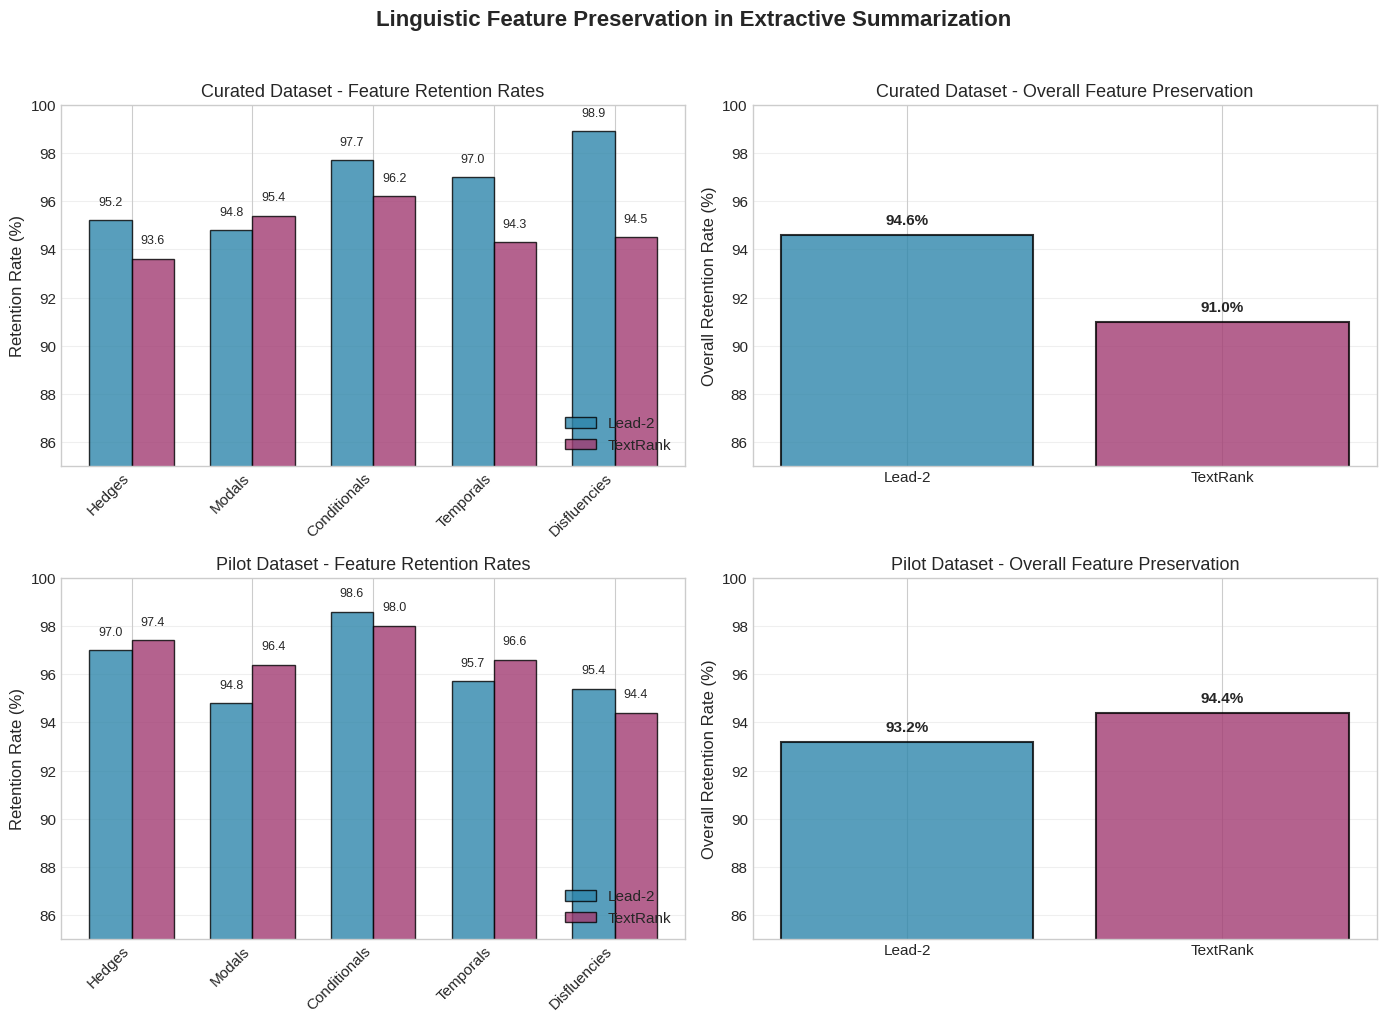

✓ Saved: feature_retention_comparison.png


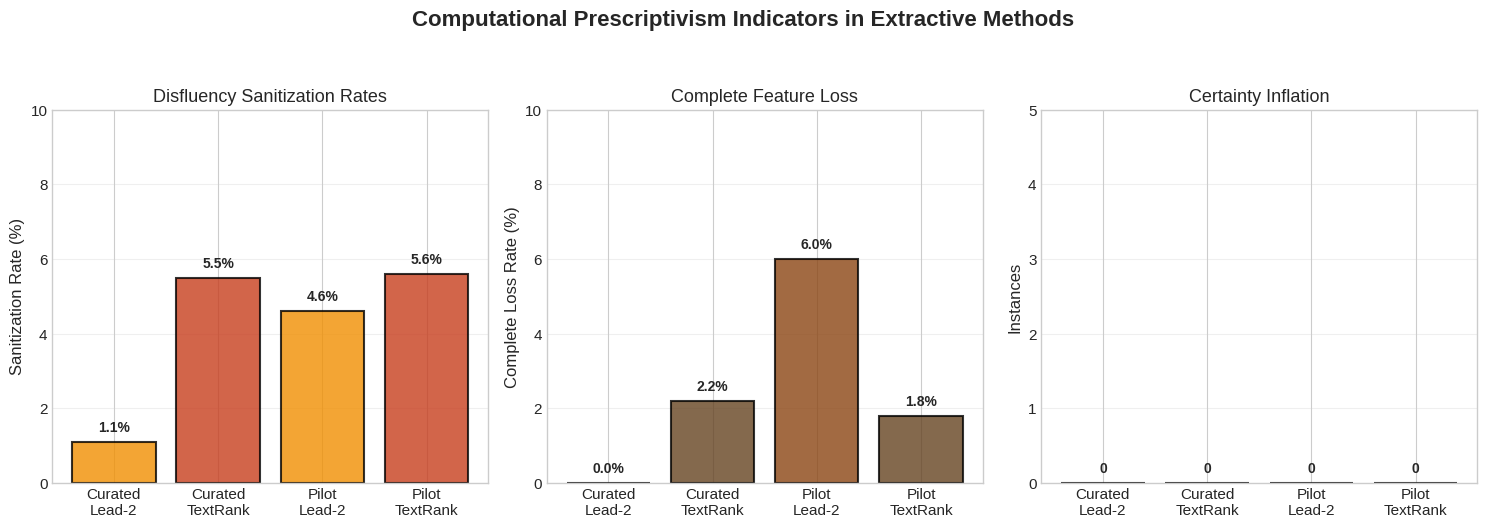

✓ Saved: prescriptivism_indicators.png


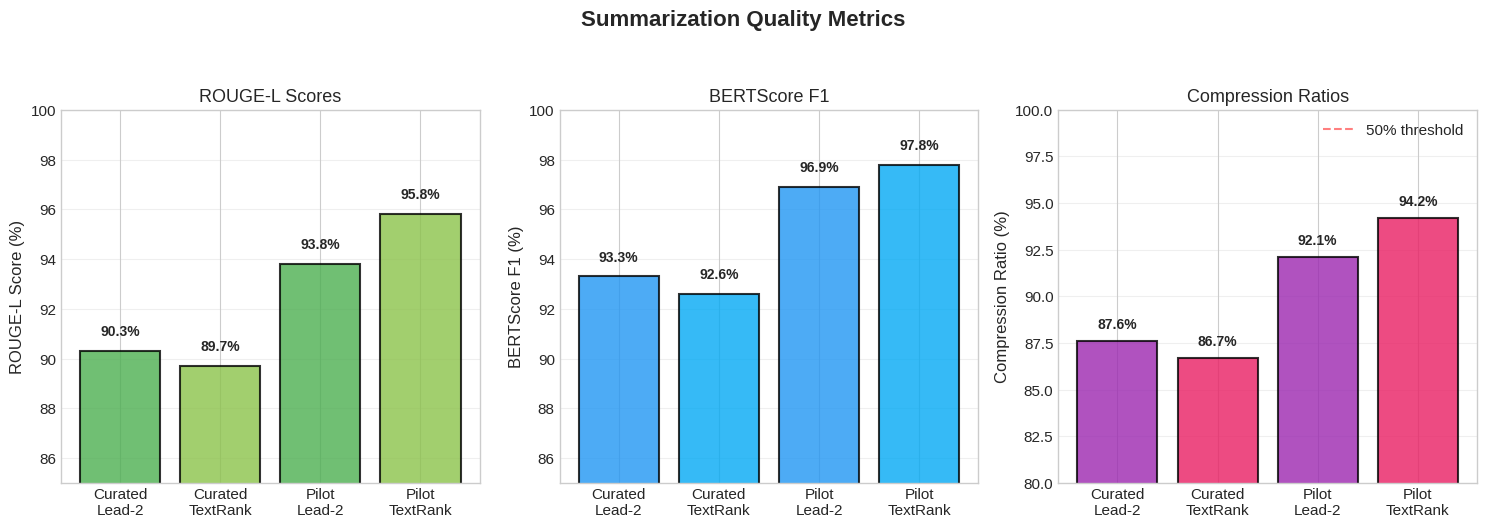

✓ Saved: quality_metrics.png


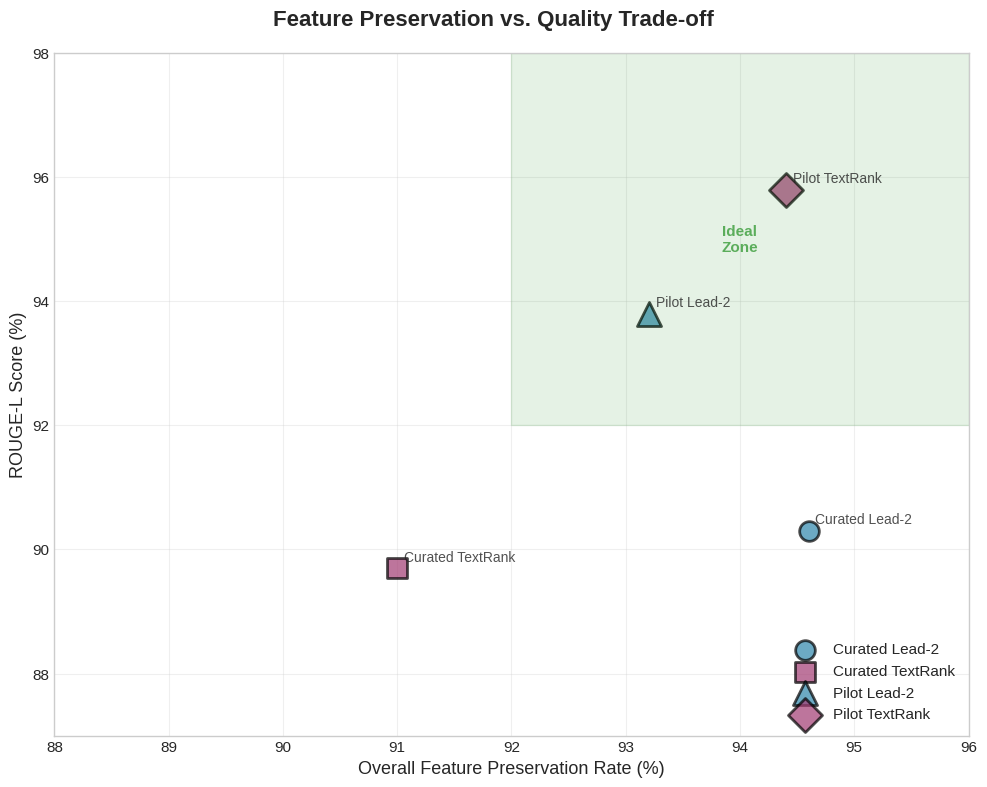

✓ Saved: preservation_quality_tradeoff.png

✅ All visualizations created successfully!

Generated files:
  1. feature_retention_comparison.png
  2. prescriptivism_indicators.png
  3. quality_metrics.png
  4. preservation_quality_tradeoff.png


In [14]:
#!/usr/bin/env python3
"""
Step 5: Create comprehensive visualizations for Section 3.4 metrics
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set publication-quality settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

print("="*60)
print("STEP 5: CREATING VISUALIZATIONS")
print("="*60)

# ==========================================
# STORE YOUR RESULTS (from previous steps)
# ==========================================

# Replace these with your actual values from Steps 3 and 4
results = {
    'curated': {
        'lead2': {
            'hedges_retention': 95.2,
            'modals_retention': 94.8,
            'conditionals_retention': 97.7,
            'temporals_retention': 97.0,
            'disfluencies_retention': 98.9,
            'overall_retention': 94.6,
            'certainty_inflation': 0,
            'disfluency_sanitization': 1.1,
            'complete_loss': 0.0,
            'rouge_l': 90.3,
            'compression_ratio': 87.6,
            'bertscore': 93.3
        },
        'textrank': {
            'hedges_retention': 93.6,
            'modals_retention': 95.4,
            'conditionals_retention': 96.2,
            'temporals_retention': 94.3,
            'disfluencies_retention': 94.5,
            'overall_retention': 91.0,
            'certainty_inflation': 0,
            'disfluency_sanitization': 5.5,
            'complete_loss': 2.2,
            'rouge_l': 89.7,
            'compression_ratio': 86.7,
            'bertscore': 92.6
        }
    },
    'pilot': {
        'lead2': {
            'hedges_retention': 97.0,
            'modals_retention': 94.8,
            'conditionals_retention': 98.6,
            'temporals_retention': 95.7,
            'disfluencies_retention': 95.4,
            'overall_retention': 93.2,
            'certainty_inflation': 0,
            'disfluency_sanitization': 4.6,
            'complete_loss': 6.0,
            'rouge_l': 93.8,
            'compression_ratio': 92.1,
            'bertscore': 96.9
        },
        'textrank': {
            'hedges_retention': 97.4,
            'modals_retention': 96.4,
            'conditionals_retention': 98.0,
            'temporals_retention': 96.6,
            'disfluencies_retention': 94.4,
            'overall_retention': 94.4,
            'certainty_inflation': 0,
            'disfluency_sanitization': 5.6,
            'complete_loss': 1.8,
            'rouge_l': 95.8,
            'compression_ratio': 94.2,
            'bertscore': 97.8
        }
    }
}

# ==========================================
# FIGURE 1: FEATURE RETENTION COMPARISON
# ==========================================

fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle('Linguistic Feature Preservation in Extractive Summarization',
              fontsize=16, fontweight='bold', y=1.02)

# Features to plot
features = ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']
feature_labels = ['Hedges', 'Modals', 'Conditionals', 'Temporals', 'Disfluencies']

# Plot for each dataset
for idx, (dataset_name, dataset_data) in enumerate([('Curated', results['curated']),
                                                     ('Pilot', results['pilot'])]):
    ax = axes[idx, 0]

    # Prepare data for grouped bar chart
    lead2_values = [dataset_data['lead2'][f'{f}_retention'] for f in features]
    textrank_values = [dataset_data['textrank'][f'{f}_retention'] for f in features]

    x = np.arange(len(features))
    width = 0.35

    bars1 = ax.bar(x - width/2, lead2_values, width, label='Lead-2',
                   color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax.bar(x + width/2, textrank_values, width, label='TextRank',
                   color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1)

    ax.set_ylabel('Retention Rate (%)', fontsize=12)
    ax.set_title(f'{dataset_name} Dataset - Feature Retention Rates', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(feature_labels, rotation=45, ha='right')
    ax.legend(loc='lower right')
    ax.set_ylim(85, 100)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Overall retention comparison
for idx, (dataset_name, dataset_data) in enumerate([('Curated', results['curated']),
                                                     ('Pilot', results['pilot'])]):
    ax = axes[idx, 1]

    methods = ['Lead-2', 'TextRank']
    overall_values = [dataset_data['lead2']['overall_retention'],
                      dataset_data['textrank']['overall_retention']]

    bars = ax.bar(methods, overall_values, color=['#2E86AB', '#A23B72'],
                  alpha=0.8, edgecolor='black', linewidth=1.5)

    ax.set_ylabel('Overall Retention Rate (%)', fontsize=12)
    ax.set_title(f'{dataset_name} Dataset - Overall Feature Preservation', fontsize=13)
    ax.set_ylim(85, 100)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_retention_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: feature_retention_comparison.png")

# ==========================================
# FIGURE 2: PROBLEMATIC METRICS
# ==========================================

fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
fig2.suptitle('Computational Prescriptivism Indicators in Extractive Methods',
              fontsize=16, fontweight='bold', y=1.05)

# Disfluency Sanitization
ax1 = axes[0]
sanitization_data = {
    'Curated\nLead-2': results['curated']['lead2']['disfluency_sanitization'],
    'Curated\nTextRank': results['curated']['textrank']['disfluency_sanitization'],
    'Pilot\nLead-2': results['pilot']['lead2']['disfluency_sanitization'],
    'Pilot\nTextRank': results['pilot']['textrank']['disfluency_sanitization']
}

bars = ax1.bar(sanitization_data.keys(), sanitization_data.values(),
               color=['#F18F01', '#C73E1D', '#F18F01', '#C73E1D'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Sanitization Rate (%)', fontsize=12)
ax1.set_title('Disfluency Sanitization Rates', fontsize=13)
ax1.set_ylim(0, 10)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Complete Feature Loss
ax2 = axes[1]
loss_data = {
    'Curated\nLead-2': results['curated']['lead2']['complete_loss'],
    'Curated\nTextRank': results['curated']['textrank']['complete_loss'],
    'Pilot\nLead-2': results['pilot']['lead2']['complete_loss'],
    'Pilot\nTextRank': results['pilot']['textrank']['complete_loss']
}

bars = ax2.bar(loss_data.keys(), loss_data.values(),
               color=['#8B4513', '#654321', '#8B4513', '#654321'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Complete Loss Rate (%)', fontsize=12)
ax2.set_title('Complete Feature Loss', fontsize=13)
ax2.set_ylim(0, 10)
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Certainty Inflation
ax3 = axes[2]
inflation_data = {
    'Curated\nLead-2': results['curated']['lead2']['certainty_inflation'],
    'Curated\nTextRank': results['curated']['textrank']['certainty_inflation'],
    'Pilot\nLead-2': results['pilot']['lead2']['certainty_inflation'],
    'Pilot\nTextRank': results['pilot']['textrank']['certainty_inflation']
}

bars = ax3.bar(inflation_data.keys(), inflation_data.values(),
               color=['#DC143C', '#8B0000', '#DC143C', '#8B0000'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Instances', fontsize=12)
ax3.set_title('Certainty Inflation', fontsize=13)
ax3.set_ylim(0, 5)
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('prescriptivism_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: prescriptivism_indicators.png")

# ==========================================
# FIGURE 3: QUALITY METRICS
# ==========================================

fig3, axes = plt.subplots(1, 3, figsize=(15, 5))
fig3.suptitle('Summarization Quality Metrics',
              fontsize=16, fontweight='bold', y=1.05)

# ROUGE-L
ax1 = axes[0]
rouge_data = {
    'Curated\nLead-2': results['curated']['lead2']['rouge_l'],
    'Curated\nTextRank': results['curated']['textrank']['rouge_l'],
    'Pilot\nLead-2': results['pilot']['lead2']['rouge_l'],
    'Pilot\nTextRank': results['pilot']['textrank']['rouge_l']
}

bars = ax1.bar(rouge_data.keys(), rouge_data.values(),
               color=['#4CAF50', '#8BC34A', '#4CAF50', '#8BC34A'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('ROUGE-L Score (%)', fontsize=12)
ax1.set_title('ROUGE-L Scores', fontsize=13)
ax1.set_ylim(85, 100)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# BERTScore
ax2 = axes[1]
bert_data = {
    'Curated\nLead-2': results['curated']['lead2']['bertscore'],
    'Curated\nTextRank': results['curated']['textrank']['bertscore'],
    'Pilot\nLead-2': results['pilot']['lead2']['bertscore'],
    'Pilot\nTextRank': results['pilot']['textrank']['bertscore']
}

bars = ax2.bar(bert_data.keys(), bert_data.values(),
               color=['#2196F3', '#03A9F4', '#2196F3', '#03A9F4'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('BERTScore F1 (%)', fontsize=12)
ax2.set_title('BERTScore F1', fontsize=13)
ax2.set_ylim(85, 100)
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Compression Ratio
ax3 = axes[2]
comp_data = {
    'Curated\nLead-2': results['curated']['lead2']['compression_ratio'],
    'Curated\nTextRank': results['curated']['textrank']['compression_ratio'],
    'Pilot\nLead-2': results['pilot']['lead2']['compression_ratio'],
    'Pilot\nTextRank': results['pilot']['textrank']['compression_ratio']
}

bars = ax3.bar(comp_data.keys(), comp_data.values(),
               color=['#9C27B0', '#E91E63', '#9C27B0', '#E91E63'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Compression Ratio (%)', fontsize=12)
ax3.set_title('Compression Ratios', fontsize=13)
ax3.set_ylim(80, 100)
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: quality_metrics.png")

# ==========================================
# FIGURE 4: PRESERVATION-QUALITY TRADE-OFF
# ==========================================

fig4, ax = plt.subplots(1, 1, figsize=(10, 8))
fig4.suptitle('Feature Preservation vs. Quality Trade-off',
              fontsize=16, fontweight='bold')

# Data points for scatter plot
scatter_data = [
    ('Curated Lead-2', results['curated']['lead2']['overall_retention'],
     results['curated']['lead2']['rouge_l'], 'o', '#2E86AB', 100),
    ('Curated TextRank', results['curated']['textrank']['overall_retention'],
     results['curated']['textrank']['rouge_l'], 's', '#A23B72', 100),
    ('Pilot Lead-2', results['pilot']['lead2']['overall_retention'],
     results['pilot']['lead2']['rouge_l'], '^', '#2E86AB', 150),
    ('Pilot TextRank', results['pilot']['textrank']['overall_retention'],
     results['pilot']['textrank']['rouge_l'], 'D', '#A23B72', 150)
]

for label, preservation, quality, marker, color, size in scatter_data:
    ax.scatter(preservation, quality, s=size*2, marker=marker,
              color=color, alpha=0.7, label=label,
              edgecolors='black', linewidth=2)

    # Add annotations
    ax.annotate(label, xy=(preservation, quality),
               xytext=(5, 5), textcoords='offset points',
               fontsize=10, alpha=0.8)

ax.set_xlabel('Overall Feature Preservation Rate (%)', fontsize=13)
ax.set_ylabel('ROUGE-L Score (%)', fontsize=13)
ax.set_xlim(88, 96)
ax.set_ylim(87, 98)
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', framealpha=0.9)

# Add ideal zone (high preservation AND high quality)
ideal_rect = plt.Rectangle((92, 92), 4, 6,
                          fill=True, alpha=0.1, color='green',
                          label='Ideal Zone')
ax.add_patch(ideal_rect)
ax.text(94, 95, 'Ideal\nZone', ha='center', va='center',
        fontsize=11, color='green', alpha=0.6, fontweight='bold')

plt.tight_layout()
plt.savefig('preservation_quality_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: preservation_quality_tradeoff.png")

print("\n" + "="*60)
print("✅ All visualizations created successfully!")
print("="*60)
print("\nGenerated files:")
print("  1. feature_retention_comparison.png")
print("  2. prescriptivism_indicators.png")
print("  3. quality_metrics.png")
print("  4. preservation_quality_tradeoff.png")

In [15]:
import os

# Create the extractive folder if it doesn't exist
output_dir = '/content/drive/MyDrive/Dissertation/extractive'
os.makedirs(output_dir, exist_ok=True)

# Save all the figures to the extractive folder
plt.figure(1)  # Go back to figure 1
plt.savefig(f'{output_dir}/feature_retention_comparison.png', dpi=300, bbox_inches='tight')

plt.figure(2)  # Go back to figure 2
plt.savefig(f'{output_dir}/prescriptivism_indicators.png', dpi=300, bbox_inches='tight')

plt.figure(3)  # Go back to figure 3
plt.savefig(f'{output_dir}/quality_metrics.png', dpi=300, bbox_inches='tight')

plt.figure(4)  # Go back to figure 4
plt.savefig(f'{output_dir}/preservation_quality_tradeoff.png', dpi=300, bbox_inches='tight')

print(f"✅ All figures saved to: {output_dir}")
print("\nSaved files:")
print("  - feature_retention_comparison.png")
print("  - prescriptivism_indicators.png")
print("  - quality_metrics.png")
print("  - preservation_quality_tradeoff.png")

✅ All figures saved to: /content/drive/MyDrive/Dissertation/extractive

Saved files:
  - feature_retention_comparison.png
  - prescriptivism_indicators.png
  - quality_metrics.png
  - preservation_quality_tradeoff.png


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>